In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
from time import time
import sys
sys.path.append('../')
from osd.utilities import progress

In [2]:
# def error(x, verbose=True):
#     ti = time()
#     T = len(x)
# #     d = np.zeros((T, T))
#     d = sparse.dok_matrix((T, T), dtype=np.float32)
# #     d[:] = np.nan
#     total = (T ** 2 + T ) / 2
#     if verbose:
#         print('{:.0f} segments to analyze'.format(total))
#         count = 0
#     else:
#         count = 12
#     for b in range(T):
#         for a in range(b+1):
#             if verbose and count % 100 == 0:
#                 progress(count, total)
#             d[a, b] = np.var(x[a:b+1]) * (b+1 - a)
#             if verbose:
#                 count += 1
#     tf = time()
#     if verbose:
#         progress(count, total, '{:.2f} seconds'.format(tf - ti))
#     return d

def error(x, verbose=True):
    ti = time()
    T = len(x)
#     d = np.zeros((T, T))
    d = sparse.lil_matrix((T, T), dtype=np.float32)
    for a in range(T):
        A_top = np.cumsum(x[a:])
        A_bot = np.arange(1, T - a + 1)
        A_row = np.divide(A_top, A_bot)
        SS_row = np.divide(np.cumsum(np.power(x[a:], 2)), A_bot)
        d[a, a:] = np.multiply(SS_row - np.power(A_row, 2), A_bot)
    tf = time()
    if verbose:
        print('{:.2f} seconds'.format(tf - ti))
    return d

def dp_seg(x, d, K, verbose=True):
    """
    :x: time series x_1, ... , x_T
    :d: Precalculated segment errors
    :K: The number of segments
    """
    ti = time()
    T = len(x)
    # Cost table
    c = np.zeros((K, T))
    c[:] = np.nan
    c[0, :] = d[0, :].toarray() # *one* segment (first index) has *zero* jumps
    # Index table
    z = np.zeros((K, T))
    z[:] = np.nan
    z[0, :] = np.arange(T)
    # Minimization
    for k in range(1, K):
        e = np.zeros((T, T))
        e[:] = np.nan
        for b_right in range(T):
            if b_right >= k:
                e_entry = [c[k - 1, b_left] + d[b_left + 1, b_right]
                           if b_left >= k - 1 
                           else np.nan 
                           for b_left in range(b_right)]
                e[b_right, :b_right] = e_entry
        slct = ~np.alltrue(np.isnan(e), axis=-1)
        c[k, slct] = np.nanmin(e[slct, :], axis=-1)
        z[k, slct] = np.nanargmin(e[slct, :], axis=-1) + 1 # the optimal b_right
    # Backtracking
    # Change points are designated by the last index of the segment. 
    # So, the last change point is always the final index
    segs = np.eye(K) * (T)
    for k1 in range(K):
        for k2 in range(1, k1+1)[::-1]:
            segs[k1, k2-1] = z[k2, int(segs[k1, k2] - 1)]
    estimate = np.ones_like(x)
    bps = np.r_[[0], segs[-1]]
    for i in range(len(bps) - 1):
        a = int(bps[i])
        b = int(bps[i + 1])
        estimate[a:b] = np.average(x[a:b])
    tf = time()
    if verbose:
        print('{:.2f} seconds'.format(tf - ti))
    return c, z, segs, estimate

def calc_cost(x, breakpoints):
    cost = 0
    bp = breakpoints
    if bp[0] != 0:
        bp = np.r_[[0], bp]
    for i in range(len(bp) - 1):
        a = int(bp[i])
        b = int(bp[i + 1])
        cost += (b - a) * np.var(x[a:b])
    return cost

In [3]:
def make_data(length, plot=True):
    x = 0.1 * np.random.randn(length)
    cp = np.zeros_like(x)
    st = int(10 * length / 50)
    tm = int(25 * length / 50)
    cp[st:tm] = 0.5
    st = int(25 * length / 50)
    tm = int(40 * length / 50)
    cp[st:tm] = -0.5
    y = cp + x
    if plot:
        plt.plot(y, marker='.')
    return y

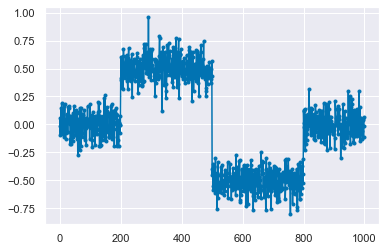

In [12]:
y = make_data(1000)

In [13]:
d = error(y)

0.24 seconds


In [25]:
c, z, segs, est = dp_seg(y, d, 4)

4.71 seconds


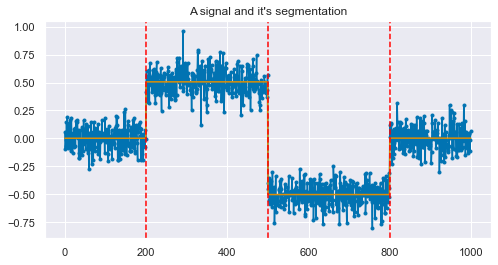

In [26]:
# c, z, segs, est = dp_seg(y, d, 4)
plt.figure(figsize=(8, 4))
plt.plot(y, marker='.')
plt.plot(est)
for bp in segs[-1][:-1]:
    plt.axvline(bp - 0.5, ls='--', color='red')
plt.title("A signal and it's segmentation");

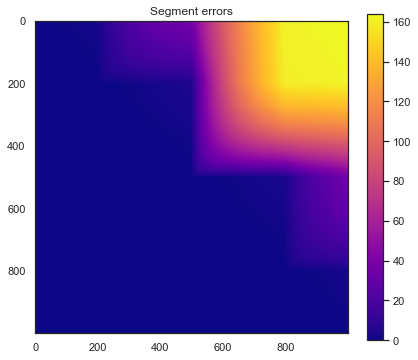

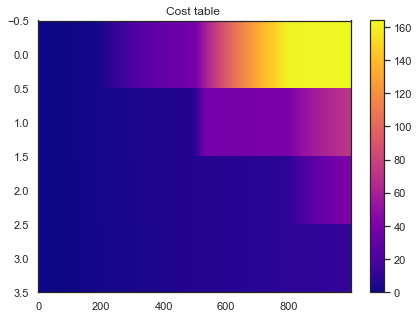

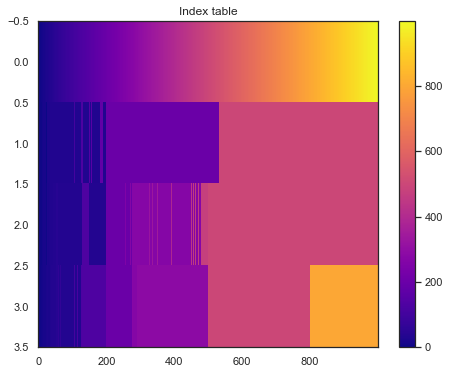

In [27]:
with sns.axes_style('white'):
    plt.figure(figsize=(7, 6))
    plt.imshow(d.toarray(), interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.title('Segment errors')
    plt.show();
with sns.axes_style('white'):
    plt.figure(figsize=(7, 5))
    plt.imshow(c, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.title('Cost table ')
    plt.show();
with sns.axes_style('white'):
    plt.figure(figsize=(7.6, 6))
    plt.imshow(z, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.title('Index table')
    plt.show();

In [9]:
Ts = np.linspace(10, 500, 11, dtype=int)
times = []
for T in Ts:
    ti = time()
    y = make_data(T, plot=False)
    d = error(y, verbose=False)
    c, z, segs, est = dp_seg(y, d, 4, verbose=False)
    tf = time()
    times.append(tf - ti)

In [10]:
table = pd.DataFrame(data={'length': Ts, 'time (seconds)': times})

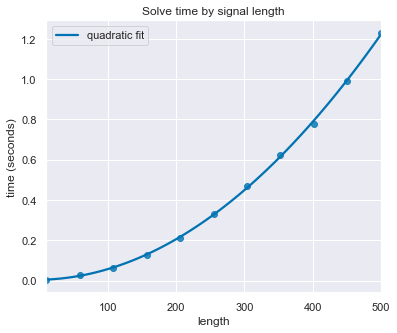

In [11]:
plt.figure(figsize=(6,5))
ax = plt.gca()
ax = sns.regplot(x='length', y='time (seconds)', data=table,
                 order=2, line_kws={'label': 'quadratic fit'}, ci=None, ax=ax)
plt.legend()
plt.title('Solve time by signal length');